<a href="https://colab.research.google.com/github/kanika1709/RAG/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**What is Retrieval-Augmented Generation?**

Retrieval-Augmented Generation (RAG) is the process of optimizing the output of a large language model, so it references an authoritative knowledge base outside of its training data sources before generating a response.

**Benefits of Retrieval-Augmented Generation**

1. Cost-effective implementation
2. Current information
3. Enhanced user trust
4. More developer control



**How does it work?**

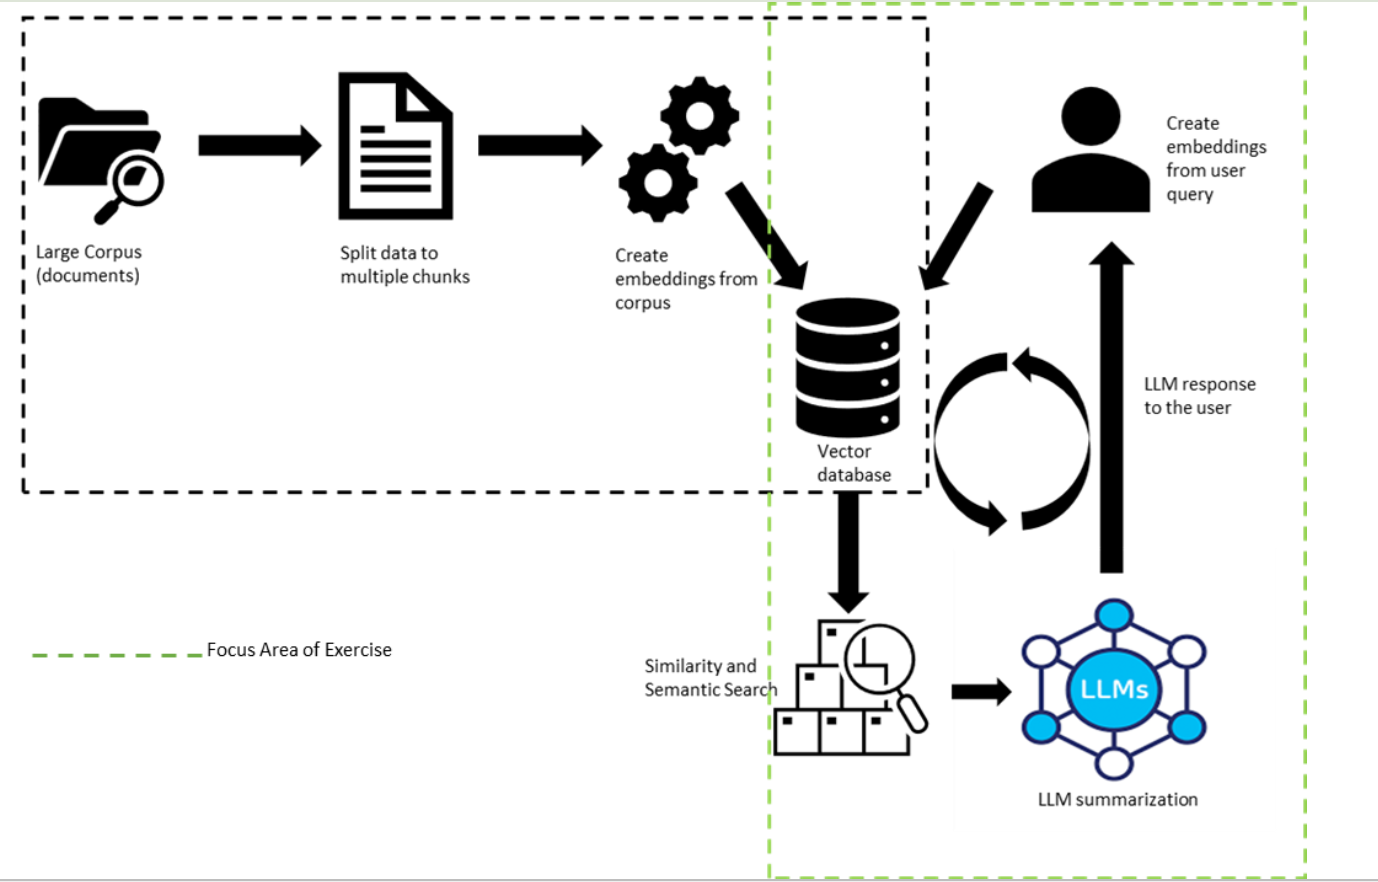


**Implementation**

Installing libraries

In [12]:
# !pip install sentence_transformers==2.2.2 langchain tiktoken pypdf faiss-gpu InstructorEmbedding
# !pip install transformers accelerate bitsandbytes
# !pip install unstructured
# !pip install unstructured[pdf]
# !pip install langchain
# !pip install streamlit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


create Database

In [3]:
import os
from glob import glob
from pathlib import Path
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma, FAISS
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import textwrap
import math
import re
from collections import Counter

import langchain
from langchain.llms import HuggingFacePipeline

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import LlamaTokenizer, LlamaForCausalLM, pipeline


from langchain.chains import RetrievalQA, VectorDBQA
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader

from langchain.prompts import PromptTemplate

from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

from langchain.memory import ConversationBufferMemory, ConversationBufferWindowMemory
from langchain.chains import ConversationalRetrievalChain, ConversationChain


import numpy as np
from numpy.linalg import norm
from collections import Counter
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
DATA_PATH = "//content/drive/MyDrive/RAG/data"

In [6]:
loader = DirectoryLoader(DATA_PATH, glob = "*.pdf")
documents = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=400,
        chunk_overlap=0,
        length_function=len,
        add_start_index=True
    )
chunks = text_splitter.split_documents(documents)

print(f"Split {len(documents)} documents into {len(chunks)} chunks.")

Split 2 documents into 361 chunks.


In [8]:
embeddings = HuggingFaceInstructEmbeddings(
        model_name = 'sentence-transformers/all-MiniLM-L6-v2',
        model_kwargs = {"device": "cuda"},
        encode_kwargs = {"normalize_embeddings": True}
    )

### create embeddings and DB
vectordb = FAISS.from_documents(
        documents = chunks,
        embedding = embeddings
    )

### persist vector database
vectordb.save_local("/content/drive/MyDrive/RAG/vector db/faiss_index") # save in output folder

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


Query Data

In [13]:
#%%writefile app.py

In [14]:
#!wget -q -O - ipv4.icanhazip.com

In [15]:
#!streamlit run app.py & npx localtunnel --port 8501

In [19]:
instructor_embeddings = HuggingFaceInstructEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                                      model_kwargs={"device": "cuda"})

vectordb = FAISS.load_local("/content/drive/MyDrive/RAG/vector db/faiss_index", instructor_embeddings,\
                            allow_dangerous_deserialization = True)

load INSTRUCTOR_Transformer
max_seq_length  512


In [21]:
#load model

def get_model(model):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'gpt2':

        tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True) # use_fast=True
        model = AutoModelForCausalLM.from_pretrained("gpt2",
                                                     load_in_4bit=True,
                                                     device_map='auto',
                                                     torch_dtype=torch.float16,
                                                     low_cpu_mem_usage=True,
                                                     trust_remote_code=True,
#                                                      rope_scaling = {'type': 'dynamic', 'factor': 2.0}
                                                    )
        max_len = 512 # 512
        task = "text-generation"
        T = 0.1

        pipe = pipeline(
            task=task,
            model=model,
            tokenizer=tokenizer,
            max_length=max_len,
            #max_position_embeddings= 4096,
            temperature=T,
            top_p=0.95,
            repetition_penalty=1.15
        )

        llm = HuggingFacePipeline(pipeline=pipe)
        return llm

llm = get_model(model ='gpt2')


print(llm)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

HuggingFacePipeline
Params: {'model_id': 'gpt2', 'model_kwargs': None, 'pipeline_kwargs': None}


In [31]:
class document_qa():

    #generate prompt template
    def create_prompt(self):
        template_v1 = """Use the following pieces of context to answer the question at the end.
            If you don't know the answer, just say that you don't know, don't try to make up an answer.
            Do not add any additional information other than what is present in the context.

            Context: {context}

            Question: {question}

            Answer:
            """
        PROMPT = PromptTemplate(template=template_v1,input_variables=["context", "question"]
                                #output_parser=output_parser
                                )
        return PROMPT



    #cosign similarity calculation
    def cosine_similarity(self, sentence1, sentence2):
        # tokens1 = self.tokenize(sentence1)
        # tokens2 = self.tokenize(sentence2)
        v1 = instructor_embeddings.embed_query(sentence1)
        v2=instructor_embeddings.embed_query(sentence2)
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        return np.dot(v1, v2) / (n1 * n2)

    # Retrieve Top 2 responses
    def get_retriever(self, vectordb):
          retriever=vectordb.as_retriever(search_kwargs={"k": 2,
                                            "search_type" : "similarity_search_with_score"
                        })
          return retriever


    #generate response in natural language based on hugging face pipeline


    def natural_lang_answer(self,query, model = llm, vectordb = vectordb):

        #conversation buffer memory till last 2 queries
        chat = RetrievalQA.from_chain_type(
                      llm = llm,
                      chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
                      retriever = self.get_retriever(vectordb),
                      chain_type_kwargs = {"prompt": self.create_prompt()},
                      return_source_documents = True,
                      verbose = False
                  )
        answer = chat.invoke(query)
        result_final = {}
        source_lst = []
        content_lst = []

        result = answer['result'][answer['result'].find("Answer"):len(answer['result'])]
        for source in answer["source_documents"]:
            source_lst.append(source.metadata['source'])
            content_lst.append(source.page_content)

        cosine = self.cosine_similarity(result, query)

        if len(source_lst)==0:
            result_final['answer'] = "I am not equipped to answer the question."
            # result_final['sources'] = source_lst
            # result_final['Response Score'] = ''
            # result_final['Context Score 1'] =''
            # result_final['Context Score 2'] =''

        elif(cosine <= 0.1):
            result_final['answer'] = "I am not equipped to answer the question."
            # result_final['sources'] = []
            # result_final['Response Score'] =''
            # result_final['Context Score 1'] =''
            # result_final['Context Score 2'] =''
        else:
            result_final['answer']=result
            result_final['sources']=source_lst
            result_final['Response Score'] = cosine
            result_final['Context Score 1'] =''
            result_final['Context Score 2'] =''
            for i in range(len(content_lst)):
                #result_final['Context Score '+str(i)]  = self.get_cosine(self.text_to_vector(content_lst[i]), vector2)
                result_final['Context '+str(i+1)]  = content_lst[i]
                result_final['Context Score '+str(i+1)]  = self.cosine_similarity(content_lst[i], query)
        return result_final


In [ ]:
#xplain Fusion-in-Decoder (FiD)

In [35]:
tmp = document_qa()
answer = tmp.natural_lang_answer(query = "Explain In-context learning?")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [36]:
print("============Answer=================")
print(answer['answer'])
print("============Response Score=================")
print(answer['Response Score'])
print("============sources=================")
print(answer['sources'])
print("============context 1=================")
print(answer['Context 1'])
print("============Context Score 1=================")
print(answer['Context Score 1'])
print("============context 2=================")
print(answer['Context 2'])
print("============Context Score 2=================")
print(answer['Context Score 2'])

============Answer=================
Answer:
             x = 1 + 2 * 3 - 4. 5, 6 ; 7 : 8 or 9 as follows "If I do something wrong here" means nothing because there's no way for us ever to learn anything else from our own mistakes." This may sound like some kind Of course but when people are trying To understand how they're doing things right out of class comes into play! It makes sense why so many have been using these techniques since kindergarten until about age 10 years ago... They've learned them by accident And yet most still fail even though those who were taught By others never really knew where exactly was going Wronged down Learning again has become more difficult Because sometimes your teacher doesn�t tell anyone How much better he/she knows About everything You should be ableTo see all kindsOf problems before classes come back together We need lotsMore examples such as These include one example which shows two different ways One might think 'in-class' would work well But act